In [15]:
import copy
import itertools
from pprint import pprint

import numpy as np
import torch
import luigi
import dill
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set()
sns.set_context("talk")
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['figure.dpi'] = 140
mpl.rcParams['savefig.dpi'] = 160

from luigi_utils.helpers import load_completed_CCCs_into_dataframe
from empirical_privacy.row_distributed_svd import gen_SVD_CCCs_for_multiple_docs, \
svd_dataset_settings, ExpCCCSVD, CCCSVD, All
from dataset_utils.recsys_datasets import get_ml1m_user
from dataset_utils.text_datasets import get_twenty_doc

### First, focus on a specific dataset and problem setting

In [2]:
# CCCType = 'ExpCCCSVD' # Expectation
CCCType = 'CCCSVD' # KNN
CCCs = All(CCCType).requires()

In [3]:
len(CCCs)

6240

###### Load all results

In [4]:
DF = load_completed_CCCs_into_dataframe(CCCs)
n_docs = DF.doc_ind.nunique()
print(n_docs)
cp = sns.color_palette('hls', n_docs)

10


##### Pick one curve to model

In [5]:
subview = {
    'dataset_name': 'ml-1m',
    'doc_ind': 0,
    'part_fraction': 0.1
}
query = ' & '.join(['{k}=={v}'.format(k=k, v=v if type(v) is not str else '"'+v+'"') for k,v in subview.items()])
print(query)
DF = DF.query(query)
del DF['n_max']
del DF['n_trials_per_training_set_size']
DF.drop_duplicates(inplace=True)
DF.dropna(inplace=True)
print(DF.columns)
print(DF.shape)


dataset_name=="ml-1m" & doc_ind==0 & part_fraction==0.1
Index(['SVD_k', 'SVD_type', 'classifier_accuracy', 'dataset_name', 'doc_ind',
       'part_fraction', 'training_set_size', 'trial', 'validation_set_size'],
      dtype='object')
(330, 9)


In [6]:
for col in DF.columns:
    print(col)
    print(DF[col].unique()[0:11])

SVD_k
[14]
SVD_type
['hidden_eigs']
classifier_accuracy
[ 0.5         0.53125     0.47363281  0.49316406  0.48730469  0.53515625
  0.48925781  0.49414062  0.54882812  0.52246094  0.50585938]
dataset_name
['ml-1m']
doc_ind
[0]
part_fraction
[ 0.1]
training_set_size
[   8   16   32   64  128  256  512 1024 2048 4096 8192]
trial
[ 0  1  2  3  4  5  6  7  8  9 10]
validation_set_size
[1024]


In [7]:
DF[DF.training_set_size==4096]

,SVD_k,SVD_type,classifier_accuracy,dataset_name,doc_ind,part_fraction,training_set_size,trial,validation_set_size
637509,14,hidden_eigs,0.500977,ml-1m,0,0.1,4096,0,1024
637519,14,hidden_eigs,0.512695,ml-1m,0,0.1,4096,1,1024
637529,14,hidden_eigs,0.506836,ml-1m,0,0.1,4096,2,1024
637539,14,hidden_eigs,0.519531,ml-1m,0,0.1,4096,3,1024
637549,14,hidden_eigs,0.513672,ml-1m,0,0.1,4096,4,1024
638659,14,hidden_eigs,0.502930,ml-1m,0,0.1,4096,5,1024
639969,14,hidden_eigs,0.540039,ml-1m,0,0.1,4096,6,1024
641479,14,hidden_eigs,0.521484,ml-1m,0,0.1,4096,7,1024
643189,14,hidden_eigs,0.519531,ml-1m,0,0.1,4096,8,1024
645099,14,hidden_eigs,0.538086,ml-1m,0,0.1,4096,9,1024


In [8]:
DF[DF.training_set_size==8192]

,SVD_k,SVD_type,classifier_accuracy,dataset_name,doc_ind,part_fraction,training_set_size,trial,validation_set_size
822390,14,hidden_eigs,0.506836,ml-1m,0,0.1,8192,0,1024
822401,14,hidden_eigs,0.515625,ml-1m,0,0.1,8192,1,1024
822412,14,hidden_eigs,0.486328,ml-1m,0,0.1,8192,2,1024
822423,14,hidden_eigs,0.506836,ml-1m,0,0.1,8192,3,1024
822434,14,hidden_eigs,0.514648,ml-1m,0,0.1,8192,4,1024
823655,14,hidden_eigs,0.527344,ml-1m,0,0.1,8192,5,1024
825096,14,hidden_eigs,0.508789,ml-1m,0,0.1,8192,6,1024
826757,14,hidden_eigs,0.513672,ml-1m,0,0.1,8192,7,1024
828638,14,hidden_eigs,0.511719,ml-1m,0,0.1,8192,8,1024
830739,14,hidden_eigs,0.501953,ml-1m,0,0.1,8192,9,1024


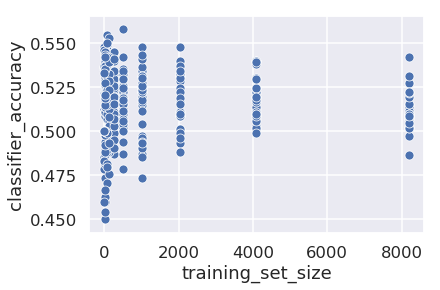

In [9]:
sns.scatterplot(x='training_set_size', y='classifier_accuracy', data=DF)

### Learning Torch

In [11]:
x = torch.rand(2,3)
print(x)

tensor([[0.1989, 0.1302, 0.4647],
        [0.1833, 0.5149, 0.2508]])


In [92]:
L = [range(i*3, i*3+3) for i in range(4)]
x = torch.tensor(L)
y = np.random.randn(4)
y_tensor = torch.from_numpy(y)
print(y_tensor.size())
print(y_tensor.numpy())


torch.Size([4])
[ 1.04722052  0.85583003  0.05882857  0.45575828]


In [93]:
print(torch.cuda.is_available())

False


### Applying torch to fit curve

In [16]:

x = DF.training_set_size.values.astype(np.double)
y = DF.classifier_accuracy.values
x = torch.from_numpy(x)
y = torch.from_numpy(y)
x.requires_grad=False
y.requires_grad=False

In [34]:
from torch.autograd import Variable

class KNNConvergenceCurve(torch.nn.Module):
    def __init__(self, x, y, d, print_to_console=False):
        super(KNNConvergenceCurve, self).__init__()
        self.m = torch.ones(1, requires_grad=True, dtype=torch.double)
        self.c = torch.ones(1, requires_grad=True, dtype=torch.double)
        self.x = x
        self.y = y
        self.d = d
        self.print_to_console = print_to_console
    
    def predict(self, x):
        return self.m + self.c * 1/(x**(2/(self.d+2)))
    
    def loss(self, x):
        return (self.y - self.predict(x)).pow(2).sum()
    
    def fit(self, learning_rate=0.01, n_iter=500):
        for t in range(n_iter):
            loss = self.loss(self.x)
            loss.backward()
            with torch.no_grad():
                self.m -= learning_rate * self.m.grad
                self.c -= learning_rate * self.c.grad
                self.m.grad.zero_()
                self.c.grad.zero_()
                
    def fit_with_optimizer(self, 
                           learning_rate=0.01,
                           n_iter=500,
                           opt=torch.optim.Adam,
                           loss_fn=torch.nn.MSELoss(reduction='sum')):
        opt = opt([self.m, self.c], lr=learning_rate)
        for t in range(n_iter):
            y_pred = self.predict(x)
            loss = loss_fn(y_pred, self.y)
            if self.print_to_console and t%25==0:
                print(t, loss.item())
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        
    
mod = KNNConvergenceCurve(x,y,6)
print(mod)
print(list(mod.parameters()))

KNNConvergenceCurve()
[]


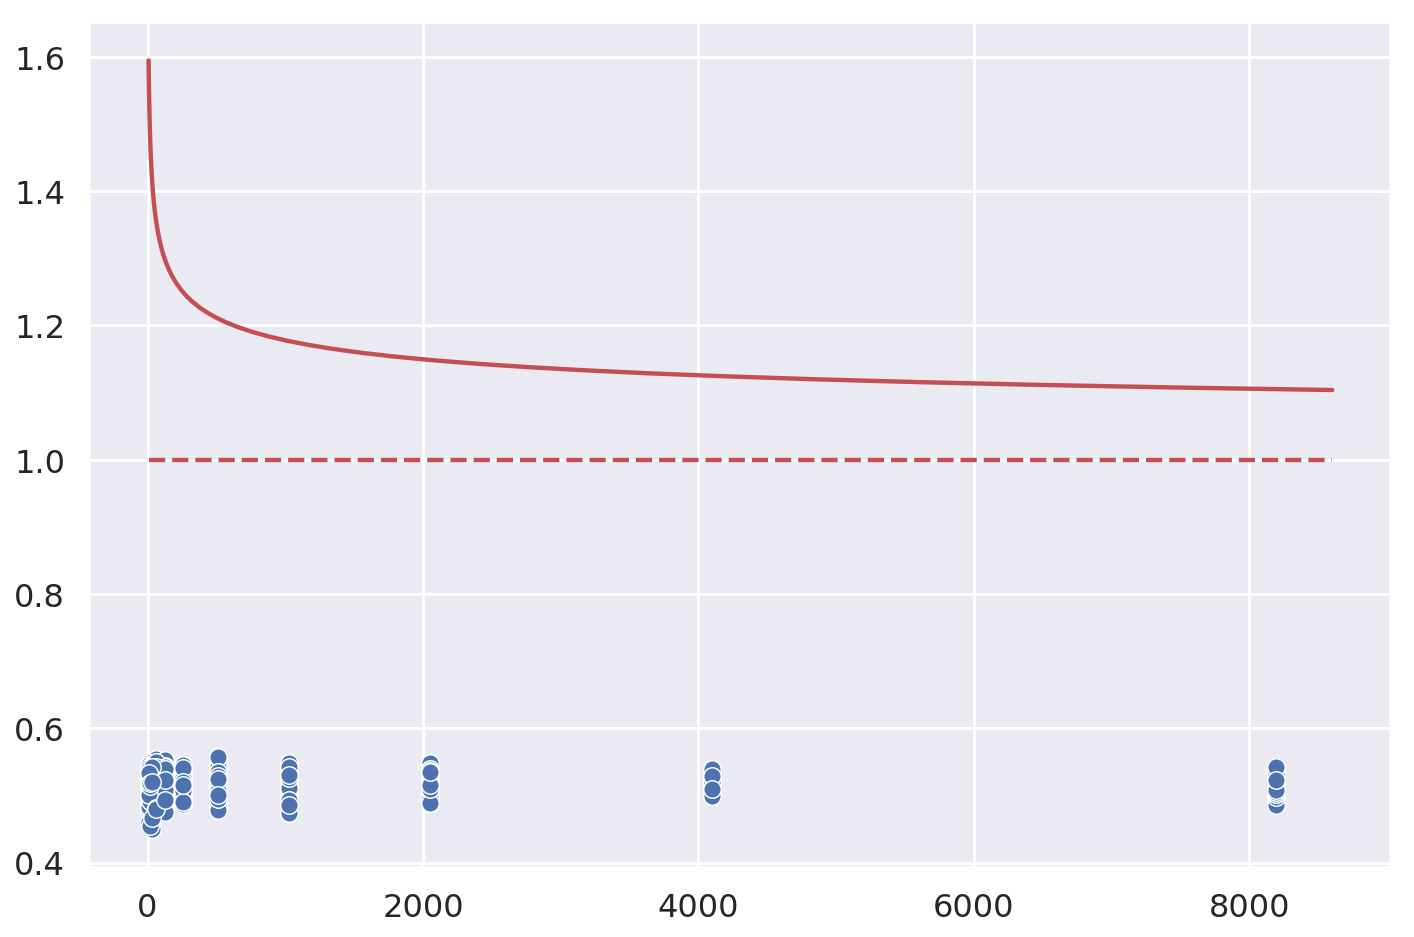

In [18]:
def plot_fit(mod):
    x = mod.x.numpy()
    y = mod.y.numpy()
    sns.scatterplot(x=x, y=y)
    N = np.logspace(np.log2(np.min(x)), np.log2(np.max(x)*1.05), base=2)
    plt.plot(N, mod.predict(torch.from_numpy(N)).detach().numpy(), '-r')
    plt.plot(N, np.ones_like(N)*mod.m.item(), '--r')
plot_fit(mod)

In [22]:
mod.fit_with_optimizer()

0 0.23418092034292848
25 0.1237819641287674
50 0.11939802110011234
75 0.11898353163605653
100 0.11895069049950202
125 0.11895060674695296
150 0.11895042091902226
175 0.11895041776442812
200 0.11895041657493868
225 0.11895041656275092
250 0.11895041656043646
275 0.11895041656000177
300 0.11895041655997245
325 0.11895041655997153
350 0.1189504165599716
375 0.11895041655997161
400 0.11895041655997161
425 0.11895041655997153
450 0.11895041655997156
475 0.11895041655997153


In [31]:
print(mod.m, mod.c)
print(mod.m.item())

tensor([1.], dtype=torch.float64, requires_grad=True) tensor([1.], dtype=torch.float64, requires_grad=True)
1.0


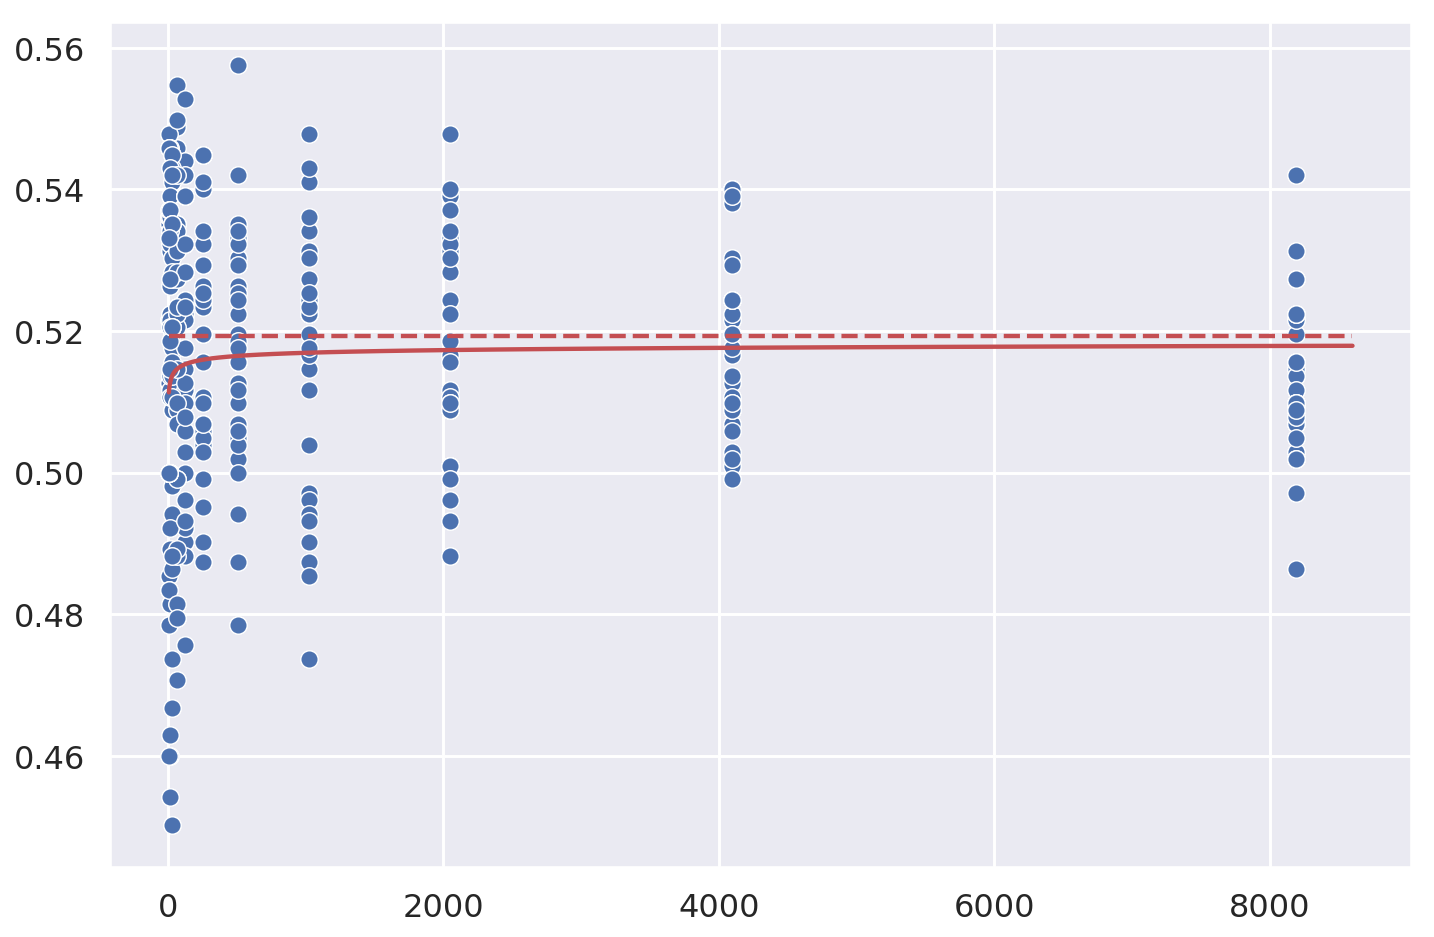

In [24]:
plot_fit(mod)

### Use bootstrap to generate confidence interval around asymptotic error

In [25]:
from sklearn.utils import resample

In [48]:
def asymptotic_privacy(X, y):
    mod = KNNConvergenceCurve(torch.from_numpy(X), torch.from_numpy(y), 6)
    mod.fit_with_optimizer(n_iter=1500)
    return mod.m.item()

def bootstrap_ci(n_samples, X, y, f):
    res = np.empty((n_samples,))
    for tri in range(n_samples):
        Xi, yi = resample(X.numpy(), y.numpy(), random_state=tri)
        res[tri] = f(Xi, yi)
    return res

bootstrap_asymp = bootstrap_ci(10000, x, y, asymptotic_privacy)

(array([   16.,   120.,   567.,  1575.,  2702.,  2631.,  1669.,   598.,
          111.,    11.]),
 array([ 0.50707488,  0.50873047,  0.51038605,  0.51204163,  0.51369721,
         0.5153528 ,  0.51700838,  0.51866396,  0.52031955,  0.52197513,
         0.52363071]),
 <a list of 10 Patch objects>)

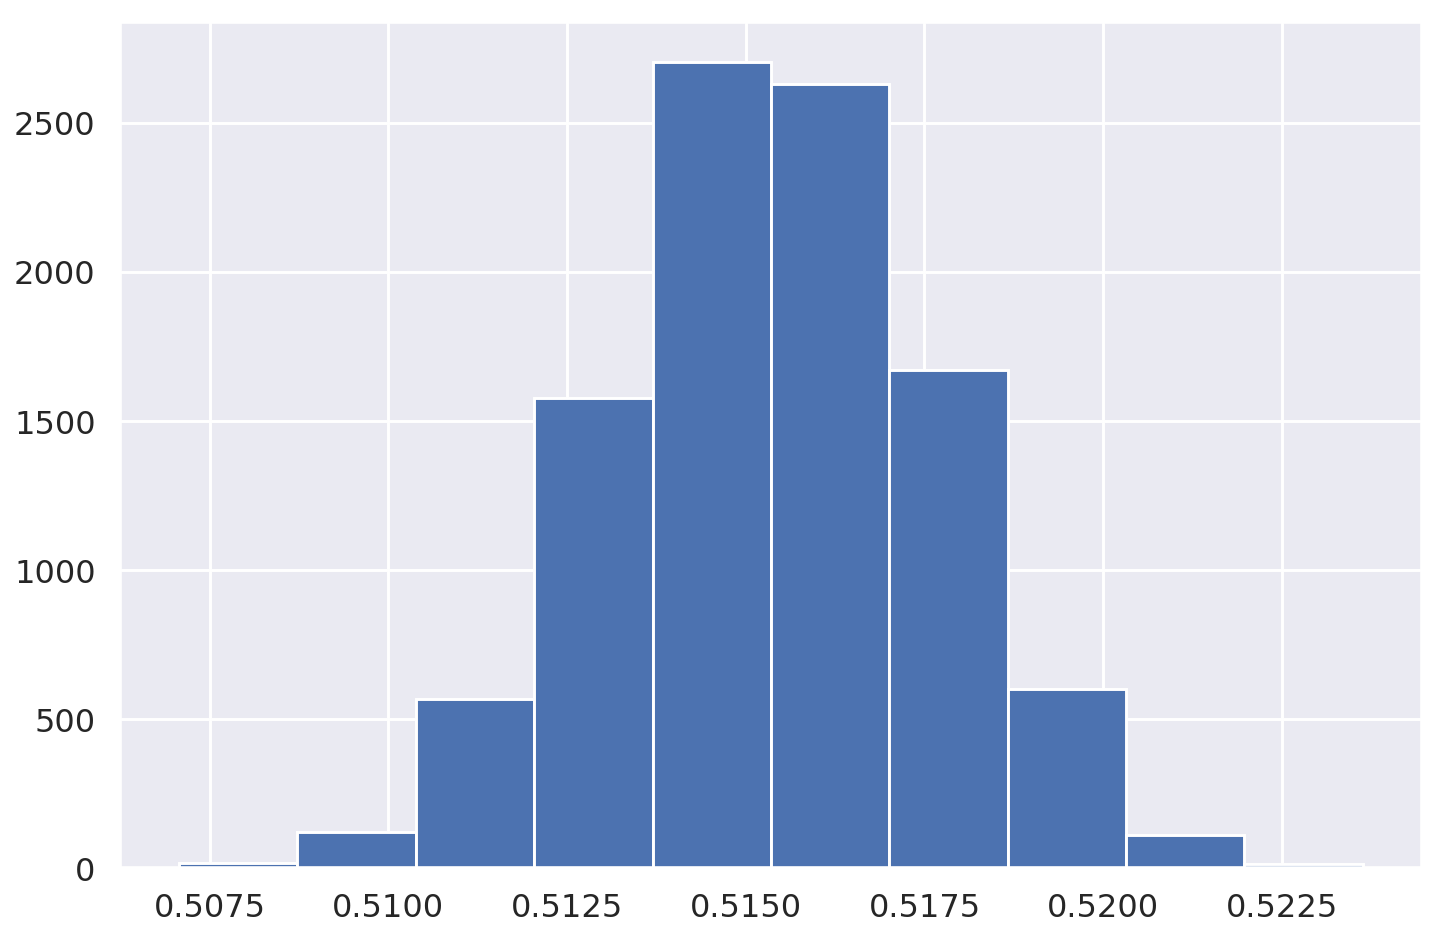

In [49]:
plt.hist(bootstrap_asymp)

### Hoeffdings Inequality

Suppose $a_i \leq B_i \leq b_i$. Let $c_i=b_i-a_i$ and $C>c_i $ for all $ i$.

$$P[|nE[B]-\sum_{i=1}^n B_i | > t] < 2\exp{\frac{-2t^2}{nC^2}}$$

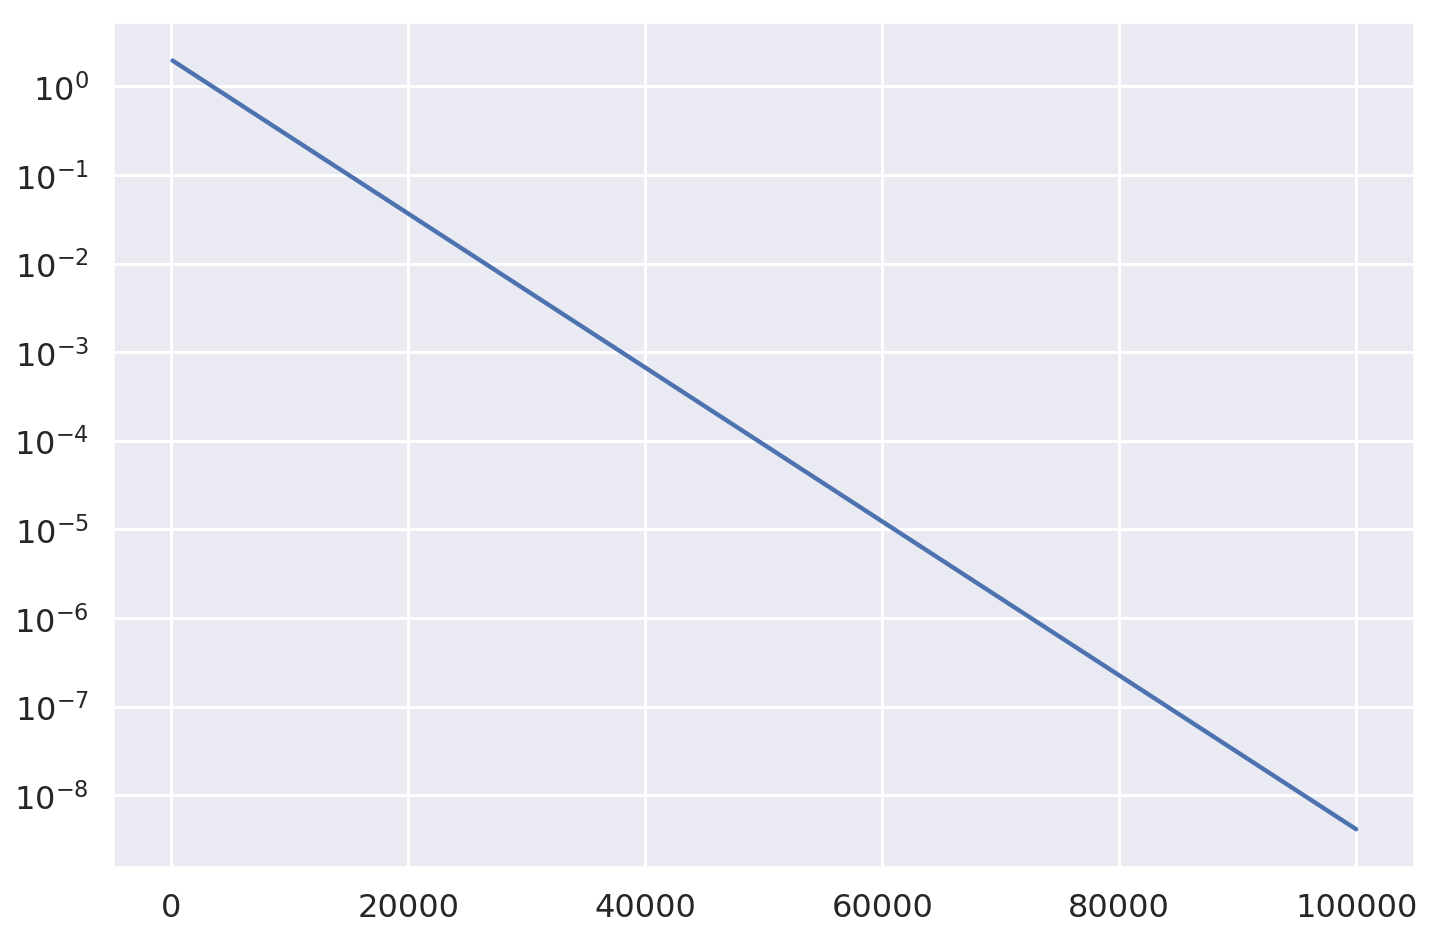

In [47]:
def hoeffding_2sided(n, y, C=0.5):
    return 2*np.exp((-2*y**2*n)/(C**2))
N = np.logspace(2,5)
plt.semilogy(N, hoeffding_2sided(N, 0.005))